In [1]:
import json
import csv
import pandas as pd
import numpy as np
import scipy as sci
import keras

from sklearn.model_selection import train_test_split
import sklearn.feature_extraction.text as sk_text
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import shutil
import os
from sklearn import metrics

from keras.models import Sequential
from keras import regularizers
from keras.layers.core import Dense, Activation
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import io
import requests
import tensorflow as tf
from scipy import sparse


C:\Users\Administrator\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
import collections
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    

In [20]:
# one-hot cooding of categorical columns

def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name]).astype(np.float32)
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    

#Function to normalize columns
def normalize_numeric_minmax(df, name):
    if(df[name].max() > 0):
        df[name] = ((df[name] - df[name].min()) / (df[name].max() - df[name].min())).astype(np.float32)
    else:
        df[name] = df[name].astype(np.float32)

# Loading and Preprocessing the dataset

In [5]:
#Reading and Loading the data into network_df dataframe 
network_df= pd.read_csv('network_intrusion_data.csv')

In [6]:
network_df.shape

(494020, 42)

In [7]:
#Adding column headers to the data in the dataframe
network_df.columns = [
'duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'outcome'
]

In [8]:
network_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.00,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.00,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.00,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.00,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.00,0.00,0.00,0.0,normal.
5,0,tcp,http,SF,212,1940,0,0,0,0,...,69,1.0,0.0,1.00,0.04,0.00,0.00,0.00,0.0,normal.
6,0,tcp,http,SF,159,4087,0,0,0,0,...,79,1.0,0.0,0.09,0.04,0.00,0.00,0.00,0.0,normal.
7,0,tcp,http,SF,210,151,0,0,0,0,...,89,1.0,0.0,0.12,0.04,0.00,0.00,0.00,0.0,normal.
8,0,tcp,http,SF,212,786,0,0,0,1,...,99,1.0,0.0,0.12,0.05,0.00,0.00,0.00,0.0,normal.
9,0,tcp,http,SF,210,624,0,0,0,0,...,109,1.0,0.0,0.06,0.05,0.00,0.00,0.00,0.0,normal.


In [9]:
network_df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'outcome'],
      dtype='object')

In [10]:
network_df.columns.isnull().sum()

0

In [11]:
# Before removing redundant values

print(network_df.outcome.value_counts())

smurf.              280790
neptune.            107201
normal.              97277
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: outcome, dtype: int64


In [12]:
print (network_df.shape)

#Drop any row with missing values
network_df = network_df.dropna()

print (network_df.shape)

#Drop redundant rows
network_df.drop_duplicates(keep='first', inplace=True)

print ("Dataframe shape after removing redundant values{} ".format(network_df.shape))

# Total Number of coumuns are 42

(494020, 42)
(494020, 42)
Dataframe shape after removing redundant values(145585, 42) 


In [13]:
network_df.outcome.value_counts()

normal.             87831
neptune.            51820
back.                 968
teardrop.             918
satan.                906
warezclient.          893
ipsweep.              651
smurf.                641
portsweep.            416
pod.                  206
nmap.                 158
guess_passwd.          53
buffer_overflow.       30
warezmaster.           20
land.                  19
imap.                  12
rootkit.               10
loadmodule.             9
ftp_write.              8
multihop.               7
phf.                    4
perl.                   3
spy.                    2
Name: outcome, dtype: int64

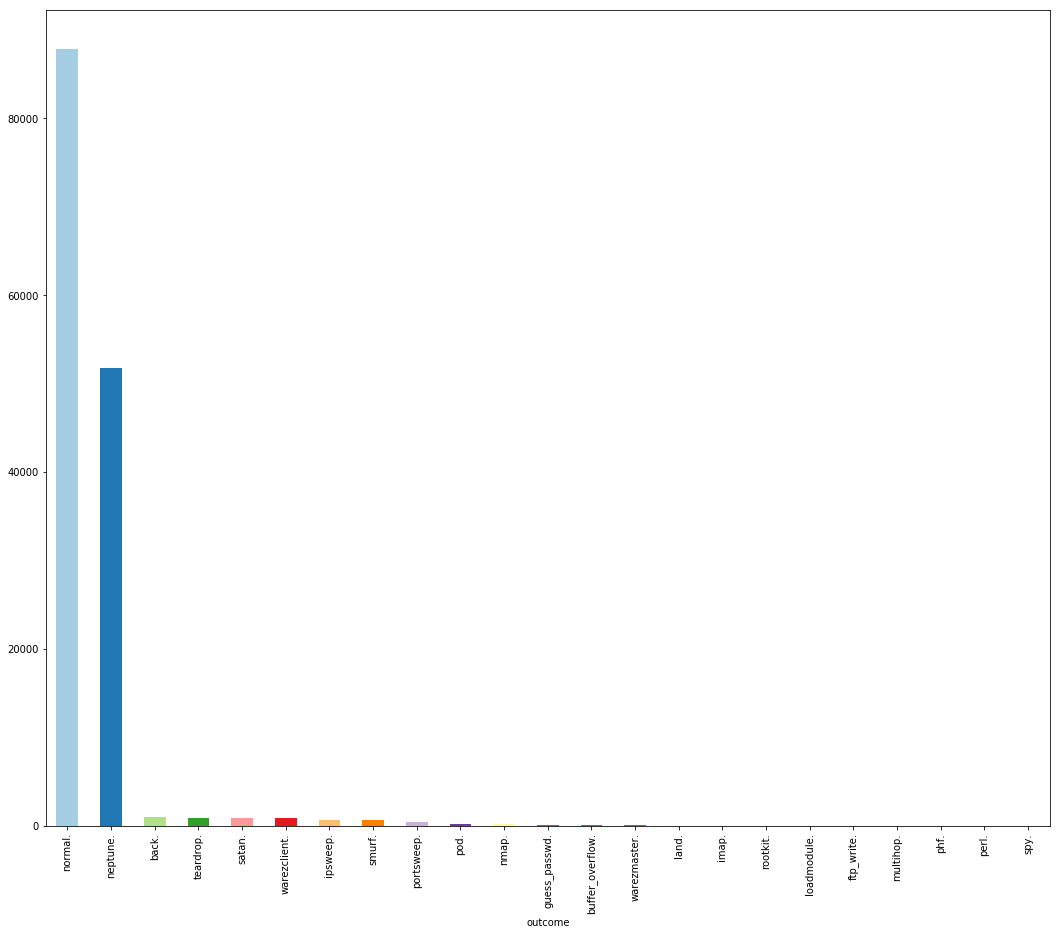

In [14]:
from IPython.display import display
import matplotlib.pyplot as plt
import random
import os
%matplotlib inline
network_df.outcome.groupby(network_df.outcome).count().sort_values()[::-1].plot(kind="bar",figsize=(18, 15),color=[plt.cm.Paired(np.arange(len(network_df['outcome'])))])

In [15]:
network_df_raw = network_df.copy()

In [16]:
network_df.nunique()

duration                        2495
protocol_type                      3
service                           66
flag                              11
src_bytes                       3300
dst_bytes                      10725
land                               2
wrong_fragment                     3
urgent                             4
hot                               22
num_failed_logins                  6
logged_in                          2
num_compromised                   23
root_shell                         2
su_attempted                       3
num_root                          20
num_file_creations                18
num_shells                         3
num_access_files                   7
num_outbound_cmds                  1
is_host_login                      1
is_guest_login                     2
count                            490
srv_count                        470
serror_rate                       92
srv_serror_rate                   51
rerror_rate                       77
s

In [17]:
network_df_raw.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [18]:
# Checking and understanding each column in the dataframe
print(network_df.land.value_counts()) # leave -2
print(network_df.logged_in.value_counts()) # leave -2
print(network_df.wrong_fragment.value_counts()) # one hot
print(network_df.urgent.value_counts()) # one hot -4
print(network_df.hot.value_counts()) # normalize
print(network_df.num_failed_logins.value_counts()) #normalize
print(network_df.num_compromised.value_counts()) # normalize 
print(network_df.root_shell.value_counts()) # leave -2
print(network_df.su_attempted.value_counts()) # one hot -3
print(network_df.num_shells.value_counts()) # one hot-3


0    145565
1        20
Name: land, dtype: int64
0    74032
1    71553
Name: logged_in, dtype: int64
0    144464
3       910
1       211
Name: wrong_fragment, dtype: int64
0    145581
1         2
3         1
2         1
Name: urgent, dtype: int64
0     143628
2        958
28       274
1        255
4        112
6        104
5         51
3         38
14        37
30        28
22        28
19        23
18        13
24        13
20        10
7          5
17         2
12         2
15         1
16         1
10         1
9          1
Name: hot, dtype: int64
0    145522
1        57
2         3
5         1
4         1
3         1
Name: num_failed_logins, dtype: int64
0      144595
1         917
2          24
4          16
3          11
6           3
5           2
7           2
12          1
9           1
11          1
767         1
884         1
16          1
18          1
275         1
21          1
22          1
281         1
38          1
102         1
238         1
13          1
Name: num_c

In [21]:
#Normalize feature input   (27)

normalize_numeric_minmax(network_df,"duration") 
normalize_numeric_minmax(network_df,"src_bytes") 
normalize_numeric_minmax(network_df,"dst_bytes")  
normalize_numeric_minmax(network_df,"hot") 
normalize_numeric_minmax(network_df,"num_failed_logins") 
normalize_numeric_minmax(network_df,"num_compromised") 
normalize_numeric_minmax(network_df,"num_root") 
normalize_numeric_minmax(network_df,"num_file_creations") 
normalize_numeric_minmax(network_df,"num_access_files") 

normalize_numeric_minmax(network_df,"count") 
normalize_numeric_minmax(network_df,"srv_count") 
normalize_numeric_minmax(network_df,"serror_rate") 
normalize_numeric_minmax(network_df,"rerror_rate") 
normalize_numeric_minmax(network_df,"srv_rerror_rate")  
normalize_numeric_minmax(network_df,"same_srv_rate") 
normalize_numeric_minmax(network_df,"diff_srv_rate") 
normalize_numeric_minmax(network_df,"srv_diff_host_rate") 
normalize_numeric_minmax(network_df,"dst_host_count") 
normalize_numeric_minmax(network_df,"dst_host_srv_count") 
normalize_numeric_minmax(network_df,"dst_host_same_srv_rate") 
normalize_numeric_minmax(network_df,"dst_host_diff_srv_rate") 
normalize_numeric_minmax(network_df,"dst_host_same_src_port_rate") 
normalize_numeric_minmax(network_df,"dst_host_srv_diff_host_rate") 
normalize_numeric_minmax(network_df,"dst_host_serror_rate") 
normalize_numeric_minmax(network_df,"dst_host_srv_serror_rate") 
normalize_numeric_minmax(network_df,"dst_host_rerror_rate") 
normalize_numeric_minmax(network_df,"dst_host_srv_rerror_rate") 

In [22]:
#One hot coding discrete values (7)
encode_text_dummy(network_df,"protocol_type") 
encode_text_dummy(network_df,"service") 
encode_text_dummy(network_df,"flag")
encode_text_dummy(network_df,"wrong_fragment") 
encode_text_dummy(network_df,"urgent") 
encode_text_dummy(network_df,"su_attempted") 
encode_text_dummy(network_df,"num_shells")  

*** Label concoding the output feature as normal = 0 and threat = 1 *** 

In [23]:
# create a function binary_encode_network to label encode the output feature
binary_encode_network = lambda x: 0 if x == 'normal.' else 1

In [24]:
label_outcome_df = network_df[['outcome']]
network_outcome_df = network_df[['outcome']]
network_df.drop(['outcome'],inplace=True, axis=1)
print(network_df.shape)
print(label_outcome_df.shape)

(145585, 127)
(145585, 1)


In [25]:
label_outcome_df = network_outcome_df.copy()

In [26]:
#Label Encode the output column 
label_outcome_df['outcome'] = label_outcome_df['outcome'].apply(binary_encode_network)

In [27]:
network_df = network_df.astype('float32')
label_outcome_df = label_outcome_df.astype('float32')

In [28]:
print(label_outcome_df.outcome.value_counts())

0.0    87831
1.0    57754
Name: outcome, dtype: int64


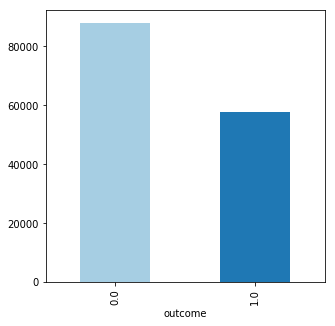

In [29]:
label_outcome_df.outcome.groupby(label_outcome_df.outcome).count().sort_values()[::-1].plot(kind="bar",figsize=(5, 5),color=[plt.cm.Paired(np.arange(len(label_outcome_df['outcome'])))])

*** Splitting the data ***

In [30]:
#Split for training and testing
x_train, x_test, y_train, y_test = train_test_split(network_df.values, label_outcome_df['outcome'].values, test_size=0.2, random_state=42)

In [31]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(116468, 127)
(116468,)
(29117, 127)
(29117,)


In [95]:
outcome_one_hot_df = label_outcome_df.copy()
print(outcome_one_hot_df)

        outcome
0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
5           0.0
6           0.0
7           0.0
8           0.0
9           0.0
10          0.0
11          0.0
12          0.0
13          0.0
14          0.0
15          0.0
16          0.0
17          0.0
18          0.0
19          0.0
20          0.0
21          0.0
22          0.0
23          0.0
24          0.0
25          0.0
26          0.0
27          0.0
28          0.0
29          0.0
...         ...
493990      0.0
493991      0.0
493992      0.0
493993      0.0
493994      0.0
493995      0.0
493996      0.0
493997      0.0
493998      0.0
493999      0.0
494000      0.0
494001      0.0
494002      0.0
494003      0.0
494004      0.0
494005      0.0
494006      0.0
494007      0.0
494008      0.0
494009      0.0
494010      0.0
494011      0.0
494012      0.0
494013      0.0
494014      0.0
494015      0.0
494016      0.0
494017      0.0
494018      0.0
494019      0.0

[145585

In [96]:
#One hot coding the output feature
encode_text_dummy(outcome_one_hot_df,"outcome")

In [97]:
outcome_one_hot_df.shape

(145585, 2)

In [98]:
print(outcome_one_hot_df.values)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [199]:
#Split for training and testing
x_train_nn, x_test_nn, y_train_nn, y_test_nn = train_test_split(network_df.values,outcome_one_hot_df.values, test_size=0.2, random_state=42)

In [200]:
print(x_train_nn.shape)
print(y_train_nn.shape)
print(x_test_nn.shape)
print(y_test_nn.shape)

(116468, 127)
(116468, 2)
(29117, 127)
(29117, 2)


# ** PyTorch Implemetation **

In [30]:
#Split for training and testing
x_train, x_test, y_train, y_test = train_test_split(network_df.values, label_outcome_df['outcome'].values, test_size=0.2, random_state=42)

In [31]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(116468, 127)
(116468,)
(29117, 127)
(29117,)


In [34]:
type(y_test)

numpy.ndarray

### Converting dataset into tensor

In [32]:
import torch
import numpy as np

In [35]:
X_train_torch = torch.from_numpy(x_train).float()
X_test_torch = torch.from_numpy(x_test).float()

In [59]:
Y_train_torch = torch.from_numpy(y_train).long().view(1,-1)[0]
Y_test_torch = torch.from_numpy(y_test).long().view(1,-1)[0]

In [60]:
print(X_train_torch.shape)
print(Y_train_torch.shape)
print(X_test_torch.shape)
print(Y_test_torch.shape)

torch.Size([116468, 127])
torch.Size([116468])
torch.Size([29117, 127])
torch.Size([29117])


In [61]:
Y_train_torch

tensor([0, 1, 0,  ..., 1, 1, 0])

In [53]:
Y_train_torch.dtype

torch.float32

###   Creating Classification Model using PyTorch

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [62]:
input_size = 127  # we have 6 input features
output_size = 2 # For 2 discrete outputs
hidden_size = 30

In [63]:
class Network(nn.Module):
    
    def __init__(self):
        super(Network, self).__init__() #super(type, obj): obj must be an instance or subtype of type
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.fc3 = nn.Linear(hidden_size, output_size) 
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))  
        
        return F.log_softmax(x, dim=-1)

In [64]:
Classification_model_torch = Network()

In [65]:
Classification_model_torch

Network(
  (fc1): Linear(in_features=127, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=2, bias=True)
)

In [66]:
import torch.optim as optim

optimizer = optim.Adam(Classification_model_torch.parameters())

loss_fn = nn.NLLLoss()

In [70]:
epoch_data = []
epochs = 3000

for epoch in range(1, epochs):

    optimizer.zero_grad()
    Y_pred = Classification_model_torch(X_train_torch)

    loss = loss_fn(Y_pred , Y_train_torch) # instead of fit we use loss.backwards()
    loss.backward()  

    optimizer.step()
        
    Y_pred_test = Classification_model_torch(X_test_torch)
    loss_test = loss_fn(Y_pred_test, Y_test_torch)
    
    _,predicted = Y_pred_test.data.max(1)
    
    accuracy = predicted.eq(Y_test_torch.data).sum().item() / y_test.size
    epoch_data.append([epoch, loss.data.item(), loss_test.data.item(), accuracy])
    
    if epoch % 100 == 0:
        print ('epoch - %d (%d%%) train loss - %.2f test loss - %.2f accuracy - %.4f'\
               % (epoch, epoch/150 * 10 , loss.data.item(), loss_test.data.item(), accuracy))

epoch - 100 (6%) train loss - 0.07 test loss - 0.07 accuracy - 0.9820
epoch - 200 (13%) train loss - 0.05 test loss - 0.05 accuracy - 0.9850
epoch - 300 (20%) train loss - 0.04 test loss - 0.04 accuracy - 0.9902
epoch - 400 (26%) train loss - 0.03 test loss - 0.03 accuracy - 0.9914
epoch - 500 (33%) train loss - 0.02 test loss - 0.02 accuracy - 0.9934
epoch - 600 (40%) train loss - 0.02 test loss - 0.02 accuracy - 0.9955
epoch - 700 (46%) train loss - 0.01 test loss - 0.01 accuracy - 0.9965
epoch - 800 (53%) train loss - 0.01 test loss - 0.01 accuracy - 0.9972
epoch - 900 (60%) train loss - 0.01 test loss - 0.01 accuracy - 0.9979
epoch - 1000 (66%) train loss - 0.01 test loss - 0.01 accuracy - 0.9981
epoch - 1100 (73%) train loss - 0.01 test loss - 0.01 accuracy - 0.9981
epoch - 1200 (80%) train loss - 0.01 test loss - 0.01 accuracy - 0.9982
epoch - 1300 (86%) train loss - 0.00 test loss - 0.01 accuracy - 0.9983
epoch - 1400 (93%) train loss - 0.00 test loss - 0.01 accuracy - 0.9984
ep

In [73]:
Y_pred_test

tensor([[ 0.0000e+00, -1.8635e+01],
        [-2.1484e+01,  0.0000e+00],
        [-2.7180e-05, -1.0513e+01],
        ...,
        [-7.3378e+00, -6.5064e-04],
        [-6.6926e+01,  0.0000e+00],
        [-6.6320e+01,  0.0000e+00]], grad_fn=<LogSoftmaxBackward>)

In [75]:
Y_pred_test1 = Classification_model_torch(X_test_torch)  # Giving the model X_model as input to make predictions

In [76]:
Y_pred_test1

tensor([[ 0.0000e+00, -1.8635e+01],
        [-2.1484e+01,  0.0000e+00],
        [-2.7180e-05, -1.0513e+01],
        ...,
        [-7.3378e+00, -6.5064e-04],
        [-6.6926e+01,  0.0000e+00],
        [-6.6320e+01,  0.0000e+00]], grad_fn=<LogSoftmaxBackward>)

In [77]:
from sklearn import metrics
score_acc = metrics.accuracy_score(Y_test_torch, predicted)
print("Accuracy score: {}".format(score_acc))

#Accuracy score: 0.9986605762956349

Accuracy score: 0.998626232098087


In [79]:
#printing the first 10 actual values and predicted values
for i in range(10):
   # indx = y_test.index[i]
    print(" Predicted Label - %s    Actual Label -  %s" 
          %(predicted[i].item(), (Y_test_torch[i])))

 Predicted Label - 0    Actual Label -  tensor(0)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 0    Actual Label -  tensor(0)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 0    Actual Label -  tensor(0)
 Predicted Label - 0    Actual Label -  tensor(0)
 Predicted Label - 0    Actual Label -  tensor(0)
 Predicted Label - 0    Actual Label -  tensor(0)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 1    Actual Label -  tensor(1)


In [80]:
import matplotlib.pyplot as plt
import pandas as pd

In [81]:
df_epochs_data = pd.DataFrame(epoch_data, 
                              columns=["epoch", "train_loss", "test_loss", "accuracy"])

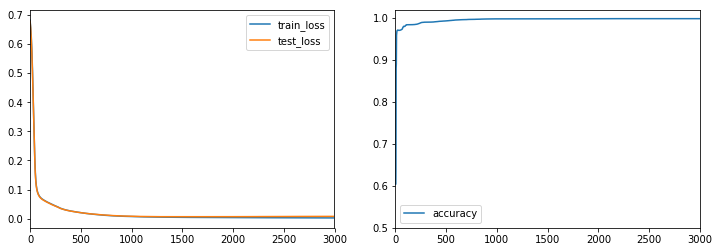

In [82]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

df_epochs_data[["train_loss", "test_loss"]].plot(ax=ax1)
df_epochs_data[["accuracy"]].plot(ax=ax2)
plt.ylim(ymin=0.5)

plt.show()

In [83]:
# Metrics

#score_log_loss = metrics.log_loss(y_test_nn, model_nn_relu.predict(x_test_nn))
#print("Log Loss: {}".format(score_log_loss))

score_nn_acc_relu = metrics.accuracy_score(Y_test_torch, predicted)
print("Accuracy score: {}".format(score_nn_acc_relu))

score_nn_precision_relu = metrics.precision_score(Y_test_torch, predicted, average= "weighted")
print("Precision score: {}".format(score_nn_precision_relu))

score_nn_recall_relu = metrics.recall_score(Y_test_torch, predicted, average= "weighted")
print("Recall score: {}".format(score_nn_recall_relu))

score_nn_f1_relu = metrics.f1_score(Y_test_torch, predicted, average= "weighted")
print("F1 score: {}".format(score_nn_f1_relu))

Accuracy score: 0.998626232098087
Precision score: 0.998626232098087
Recall score: 0.998626232098087
F1 score: 0.998626232098087


In [84]:
cm_nn_torch = confusion_matrix(Y_test_torch, predicted)
print(cm_nn_torch)

[[17569    20]
 [   20 11508]]


Plotting confusion matrix


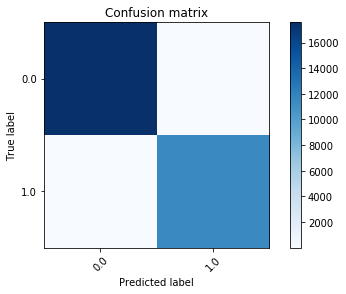

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     17589
          1       1.00      1.00      1.00     11528

avg / total       1.00      1.00      1.00     29117



In [86]:
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm_nn_torch,label_outcome_df['outcome'].unique())
plt.show()
print(classification_report(Y_test_torch, predicted))

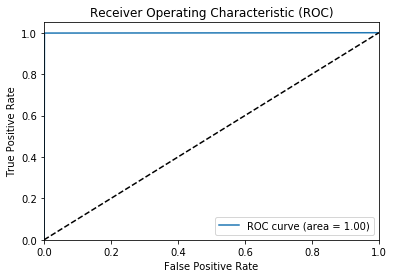

In [91]:
plot_roc(predicted,Y_test_torch)

In [92]:
Classification_model_torch.eval()  

Network(
  (fc1): Linear(in_features=127, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=2, bias=True)
)

In [93]:
Classification_model_torch

Network(
  (fc1): Linear(in_features=127, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=2, bias=True)
)

# multi-class classification

In [129]:
print(network_df.shape)
print(network_outcome_df.shape)

(145585, 127)
(145585, 1)


In [130]:
df = network_outcome_df.copy()

In [131]:
network_outcome_df.outcome.value_counts()

normal.             87831
neptune.            51820
back.                 968
teardrop.             918
satan.                906
warezclient.          893
ipsweep.              651
smurf.                641
portsweep.            416
pod.                  206
nmap.                 158
guess_passwd.          53
buffer_overflow.       30
warezmaster.           20
land.                  19
imap.                  12
rootkit.               10
loadmodule.             9
ftp_write.              8
multihop.               7
phf.                    4
perl.                   3
spy.                    2
Name: outcome, dtype: int64

In [132]:
df.replace('back.', 'DOS',inplace =True) 
df.replace('buffer_overflow.', 'U2R',inplace =True) 
df.replace('ftp_write.', 'R2L',inplace =True) 
df.replace('guess_passwd.', 'R2L',inplace =True) 
df.replace('imap.', 'R2L',inplace =True) 
df.replace('ipsweep.', 'Probing',inplace =True) 
df.replace('land.', 'DOS',inplace =True) 
df.replace('loadmodule.', 'U2R',inplace =True) 
df.replace('multihop.', 'R2L',inplace =True) 
df.replace('neptune.', 'DOS',inplace =True) 
df.replace('nmap.', 'Probing',inplace =True) 
df.replace('perl.', 'U2R',inplace =True) 
df.replace('phf.', 'R2L',inplace =True) 
df.replace('pod.', 'DOS',inplace =True) 
df.replace('portsweep.', 'Probing',inplace =True) 
df.replace('rootkit.', 'U2R',inplace =True) 
df.replace('satan.', 'Probing',inplace =True) 
df.replace('smurf.', 'DOS',inplace =True) 
df.replace('spy.', 'R2L',inplace =True) 
df.replace('teardrop.', 'DOS',inplace =True) 
df.replace('warezclient.', 'R2L',inplace =True) 
df.replace('warezmaster.', 'R2L',inplace =True) 
df.replace('normal.', 'NONE',inplace =True) 


In [133]:
# label Encoding the output feature for classification models
outcome_label = encode_text_index(outcome_label,'outcome')

NameError: name 'encode_text_index' is not defined

In [134]:
le = preprocessing.LabelEncoder()
df['label'] = le.fit_transform(df['outcome'])

In [135]:
df.label.value_counts()

1    87831
0    54572
2     2131
3      999
4       52
Name: label, dtype: int64

In [136]:
#printing the labels to be predicted
le_name_mapping1 = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping1)

{'DOS': 0, 'NONE': 1, 'Probing': 2, 'R2L': 3, 'U2R': 4}


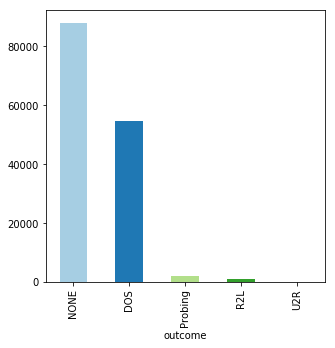

In [137]:
df.outcome.groupby(df.outcome).count().sort_values()[::-1].plot(kind="bar",figsize=(5, 5),color=[plt.cm.Paired(np.arange(len(df['outcome'])))])

In [138]:
#Split for training and testing
x_train_mc, x_test_mc, y_train_mc, y_test_mc = train_test_split(network_df, df['label'], test_size=0.2, random_state=42)


In [139]:
print(x_train_mc.shape)
print(y_train_mc.shape)
print(x_test_mc.shape)
print(y_test_mc.shape)

(116468, 127)
(116468,)
(29117, 127)
(29117,)


# ** PyTorch Multi- Classifier**

In [140]:
import torch
import numpy as np

In [142]:
X_train_torch = torch.from_numpy(x_train_mc.values).float()
X_test_torch = torch.from_numpy(x_test_mc.values).float()

In [144]:
Y_train_torch = torch.from_numpy(y_train_mc.values).long().view(1,-1)[0]
Y_test_torch = torch.from_numpy(y_test_mc.values).long().view(1,-1)[0]

In [145]:
print(X_train_torch.shape)
print(Y_train_torch.shape)
print(X_test_torch.shape)
print(Y_test_torch.shape)

torch.Size([116468, 127])
torch.Size([116468])
torch.Size([29117, 127])
torch.Size([29117])


In [147]:
Y_train_torch.unique()

tensor([1, 0, 3, 2, 4])

In [148]:
Y_train_torch.dtype

torch.int64

##  Creating Classification Model using PyTorch

In [149]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [150]:
input_size = 127  # we have 6 input features
output_size = 5 # For 2 discrete outputs
hidden_size = 30

In [151]:
class Network(nn.Module):
    
    def __init__(self):
        super(Network, self).__init__() #super(type, obj): obj must be an instance or subtype of type
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.fc3 = nn.Linear(hidden_size, output_size) 
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=-1)

In [152]:
Classification_model_torch = Network()

In [153]:
Classification_model_torch

Network(
  (fc1): Linear(in_features=127, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=5, bias=True)
)

In [154]:
import torch.optim as optim

optimizer = optim.Adam(Classification_model_torch.parameters())

loss_fn = nn.NLLLoss()

In [155]:
epoch_data = []
epochs = 1000

for epoch in range(1, epochs):

    optimizer.zero_grad()
    Y_pred = Classification_model_torch(X_train_torch)

    loss = loss_fn(Y_pred , Y_train_torch) # instead of fit we use loss.backwards()
    loss.backward()  

    optimizer.step()
        
    Y_pred_test = Classification_model_torch(X_test_torch)
    loss_test = loss_fn(Y_pred_test, Y_test_torch)
    
    _,predicted = Y_pred_test.data.max(1)
    
    accuracy = predicted.eq(Y_test_torch.data).sum().item() / y_test.size
    epoch_data.append([epoch, loss.data.item(), loss_test.data.item(), accuracy])
    
    if epoch % 100 == 0:
        print ('epoch - %d (%d%%) train loss - %.2f test loss - %.2f accuracy - %.4f'\
               % (epoch, epoch/150 * 10 , loss.data.item(), loss_test.data.item(), accuracy))

epoch - 100 (6%) train loss - 0.20 test loss - 0.19 accuracy - 0.9612
epoch - 200 (13%) train loss - 0.11 test loss - 0.10 accuracy - 0.9733
epoch - 300 (20%) train loss - 0.06 test loss - 0.06 accuracy - 0.9834
epoch - 400 (26%) train loss - 0.04 test loss - 0.04 accuracy - 0.9894
epoch - 500 (33%) train loss - 0.03 test loss - 0.03 accuracy - 0.9922
epoch - 600 (40%) train loss - 0.02 test loss - 0.02 accuracy - 0.9940
epoch - 700 (46%) train loss - 0.02 test loss - 0.02 accuracy - 0.9956


KeyboardInterrupt: 

In [156]:
Y_pred_test

tensor([[-6.9026e+00, -1.0524e-03, -1.2171e+01, -1.0565e+01, -1.1060e+01],
        [-8.5260e+00, -9.2244e+00, -3.1185e-04, -1.1653e+01, -1.1978e+01],
        [-4.6688e+00, -9.5177e-03, -1.1445e+01, -9.7807e+00, -1.0723e+01],
        ...,
        [-9.6602e-03, -4.8734e+00, -6.2682e+00, -9.7286e+00, -1.1383e+01],
        [-9.5367e-06, -2.1243e+01, -1.1530e+01, -1.8946e+01, -1.9021e+01],
        [-1.0490e-05, -2.1108e+01, -1.1464e+01, -1.8834e+01, -1.8904e+01]],
       grad_fn=<LogSoftmaxBackward>)

In [157]:
Y_pred_test1 = Classification_model_torch(X_test_torch)  # Giving the model X_model as input to make predictions

In [158]:
Y_pred_test1

tensor([[-6.9026e+00, -1.0524e-03, -1.2171e+01, -1.0565e+01, -1.1060e+01],
        [-8.5260e+00, -9.2244e+00, -3.1185e-04, -1.1653e+01, -1.1978e+01],
        [-4.6688e+00, -9.5177e-03, -1.1445e+01, -9.7807e+00, -1.0723e+01],
        ...,
        [-9.6602e-03, -4.8734e+00, -6.2682e+00, -9.7286e+00, -1.1383e+01],
        [-9.5367e-06, -2.1243e+01, -1.1530e+01, -1.8946e+01, -1.9021e+01],
        [-1.0490e-05, -2.1108e+01, -1.1464e+01, -1.8834e+01, -1.8904e+01]],
       grad_fn=<LogSoftmaxBackward>)

In [159]:
from sklearn import metrics
score_acc = metrics.accuracy_score(Y_test_torch, predicted)
print("Accuracy score: {}".format(score_acc))

#Accuracy score: 0.9986605762956349

Accuracy score: 0.9961191056770958


In [163]:
#printing the first 10 actual values and predicted values
for i in range(1000,1500):
   # indx = y_test.index[i]
    print(" Predicted Label - %s    Actual Label -  %s" 
          %(predicted[i].item(), (Y_test_torch[i])))

 Predicted Label - 0    Actual Label -  tensor(0)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 0    Actual Label -  tensor(0)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 3    Actual Label -  tensor(3)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 0    Actual Label -  tensor(0)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 0    Actual Label -  tensor(0)
 Predicted Label - 1    Actual Label -  tensor(1)


 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 0    Actual Label -  tensor(0)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 0    Actual Label -  tensor(0)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 0    Actual Label -  tensor(0)
 Predicted Label - 0    Actual Label -  tensor(0)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 0    Actual Label -  tensor(0)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 1    Actual Label -  tensor(1)
 Predicted Label - 0    Actual Label -  tensor(0)


In [80]:
import matplotlib.pyplot as plt
import pandas as pd

In [164]:
df_epochs_data = pd.DataFrame(epoch_data, 
                              columns=["epoch", "train_loss", "test_loss", "accuracy"])

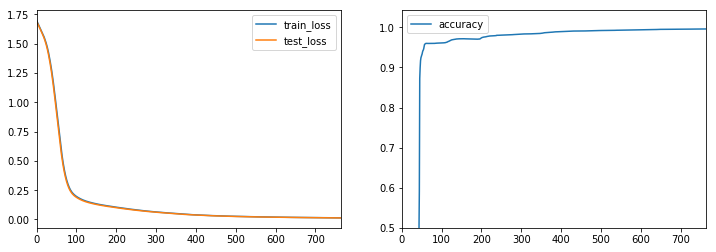

In [165]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

df_epochs_data[["train_loss", "test_loss"]].plot(ax=ax1)
df_epochs_data[["accuracy"]].plot(ax=ax2)
plt.ylim(ymin=0.5)

plt.show()

In [166]:
# Metrics

#score_log_loss = metrics.log_loss(y_test_nn, model_nn_relu.predict(x_test_nn))
#print("Log Loss: {}".format(score_log_loss))

score_nn_acc_relu = metrics.accuracy_score(Y_test_torch, predicted)
print("Accuracy score: {}".format(score_nn_acc_relu))

score_nn_precision_relu = metrics.precision_score(Y_test_torch, predicted, average= "weighted")
print("Precision score: {}".format(score_nn_precision_relu))

score_nn_recall_relu = metrics.recall_score(Y_test_torch, predicted, average= "weighted")
print("Recall score: {}".format(score_nn_recall_relu))

score_nn_f1_relu = metrics.f1_score(Y_test_torch, predicted, average= "weighted")
print("F1 score: {}".format(score_nn_f1_relu))

Accuracy score: 0.9961191056770958
Precision score: 0.9961859948991131
Recall score: 0.9961191056770958
F1 score: 0.9960830855585417


In [167]:
cm_nn_torch = confusion_matrix(Y_test_torch, predicted)
print(cm_nn_torch)

[[10890    34     0     0     0]
 [    9 17556     3    21     0]
 [    7    19   397     2     0]
 [    0    13     0   159     0]
 [    0     1     0     4     2]]


Plotting confusion matrix


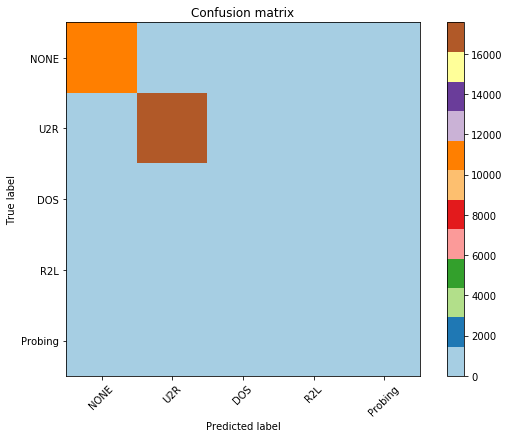

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     10924
          1       1.00      1.00      1.00     17589
          2       0.99      0.93      0.96       425
          3       0.85      0.92      0.89       172
          4       1.00      0.29      0.44         7

avg / total       1.00      1.00      1.00     29117



In [174]:
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm_nn_torch,df['outcome'].unique())
plt.show()
print(classification_report(Y_test_torch, predicted))

Plotting confusion matrix


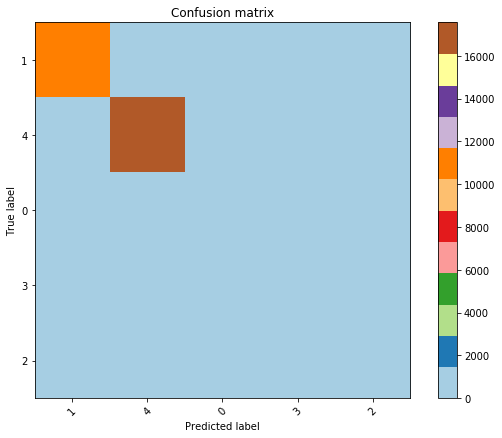

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     10924
          1       1.00      1.00      1.00     17589
          2       0.99      0.93      0.96       425
          3       0.85      0.92      0.89       172
          4       1.00      0.29      0.44         7

avg / total       1.00      1.00      1.00     29117



In [177]:
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm_nn_torch,df['label'].unique())
plt.show()
print(classification_report(Y_test_torch, predicted))

In [169]:
plot_roc(predicted,Y_test_torch)

ValueError: multiclass format is not supported

In [170]:
Classification_model_torch.eval()  

Network(
  (fc1): Linear(in_features=127, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=5, bias=True)
)

In [171]:
Classification_model_torch

Network(
  (fc1): Linear(in_features=127, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=5, bias=True)
)